In [1]:
import pandas as pd
import os
from pickle import load

from cobra.flux_analysis.deletion import single_gene_deletion
from matplotlib.pylab import plt
import matplotlib

In [2]:
# Only include the species that we have essentiality datasets for.
species_w_essentiality = ['Staphylococcus aureus','Streptococcus pneumoniae', 'Haemophilus influenzae']

# read in the PATRIC feature tables for organisms we have gene essentiality data for
saureus_genomic = pd.read_csv(
    '../data/essentiality/PATRIC_Saureus_NCTC_8325_genome_feature.csv',
    sep=',')
spneumoniae_genomic = pd.read_csv(
    '../data/essentiality/PATRIC_Spneumoniae_R6_genome_feature.csv',
    sep=',')
hinfluenzae_genomic = pd.read_csv(
    '../data/essentiality/PATRIC_Hinfluenzae_Rd_KW20_genome_feature.csv',
    sep=',')

# read in the gene essentiality datasets
spneumoniae_data = pd.read_csv(
    '../data/essentiality/Streptococcus pneumoniae R6_consolidated.csv',
    sep=',')
saureus_data = pd.read_csv(
    '../data/essentiality/Staphylococcus aureus subsp. aureus NCTC 8325_consolidated.csv',
    sep=',')
hinfluenzae_data = pd.read_csv(
    '../data/essentiality/Haemophilus influenzae Rd KW20_consolidated.csv',
    sep=',')


# generate dictionaries to store data for all species to make iteration easier
essentiality_data = {}
genome_tables = {}

essentiality_data['Staphylococcus aureus'] = saureus_data
essentiality_data['Streptococcus pneumoniae'] = spneumoniae_data
essentiality_data['Haemophilus influenzae'] = hinfluenzae_data

genome_tables['Staphylococcus aureus'] = saureus_genomic
genome_tables['Streptococcus pneumoniae'] = spneumoniae_genomic
genome_tables['Haemophilus influenzae'] = hinfluenzae_genomic

In [3]:
# load the ensembles for these species
# load all ensembles
ensembles = {}
for species_file in os.listdir("../results/deep_ensembles/"):
    species_name = species_file.split(".")[0]
    
    if species_name in species_w_essentiality:
        with open("../results/deep_ensembles/"+species_name+".pickle",'rb') as infile:
            ensembles[species_name] = load(infile)

# load the essentiality results for these species
gene_knockout_results = {}    
for fname in os.listdir('../results/gene_knockouts/'):
    species = fname.split('.')[0]
    if species in species_w_essentiality:
        gene_knockout_results[species] = pd.read_csv(
            '../results/gene_knockouts/'+species+'.csv',sep=',',index_col=0)
            

In [4]:
# get the previously determined knockout results, which includes results for all genes except
# those that were predicted to be essential in every ensemble member
#spneumoniae_ensemble_knockouts = gene_knockout_results['Streptococcus pneumoniae']
#saureus_ensemble_knockouts = gene_knockout_results['Staphylococcus aureus']

for species in species_w_essentiality:
    # convert the simulation results to True/False, where True is essential
    # and False is non-essential
    #ten_per = gene_knockout_results[species].max()*0.10
    gene_knockout_results[species] = gene_knockout_results[species] < 1E-6

    # determine the constitutively essential genes and add them to the knockout simulation results
    ensemble = ensembles[species]
    for feature in ensemble.features:
        component = ensemble.base_model.reactions.get_by_id(feature.base_component.id)
        component.lower_bound = -1000
        component.upper_bound = 1000
    always_essential = single_gene_deletion(ensemble.base_model)
    always_essential = always_essential.loc[always_essential['growth'] < 1E-6]
    always_essential.index = [list(gene)[0] for gene in always_essential.index]
    always_essential_genes = always_essential.index.tolist()
    always_essential_df = pd.DataFrame(False,columns = gene_knockout_results[species].columns,
                                      index=always_essential_genes)

    gene_knockout_results[species] = gene_knockout_results[species].append(always_essential_df)


In [5]:
# rename the locus column for merging the experimental and genomic data
merged_data = {}
for species in species_w_essentiality:
    genomic = genome_tables[species]
    genomic = genomic.rename({'RefSeq Locus Tag':'locus'},axis='columns')
    
    # merge the experimental and genomic annotaions, keeping only the genes with 
    # experimental data and genomic annotations
    merged_data[species] = essentiality_data[species].merge(genomic,on='locus',how='inner')
    
    # convert the essentiality status to True/False for ease of processing.
    # True is essential, False is non-essential
    merged_data[species] = merged_data[species].replace({'essentiality status':{'E':True,'NE':False}})


In [6]:
genes_in_models = {}
annotated_exp_genes = {}
genes_in_all = {}
member_ids = {}
masters = {}
for species in species_w_essentiality:
    # get genes in the model
    genes_in_models[species] = [g.id for g in ensembles[species].base_model.genes]
    
    # get genes in the genomic annotations, in PATRIC ID format. String splitting
    # gets rid of 'fig|', which is in all the genome table PATRIC IDs.
    annotated_exp_genes[species] = [x[1] for x in merged_data[species]['PATRIC ID'].str.split('|')]
    
    # determine genes in both the genome tables and the models
    genes_in_all[species] = list(set(annotated_exp_genes[species]) &
                                set(genes_in_models[species]))
    
    # Filter the knockout predictions by genes with experimental data
    gene_knockout_results[species] = gene_knockout_results[species].loc[
        gene_knockout_results[species].index.intersection(genes_in_all[species])]
    
    # add a model gene id column to merge with the experimental data
    # get the columns specifying ensemble members, which we'll need to select later on
    member_ids[species] = gene_knockout_results[species].columns
    gene_knockout_results[species]['model_gene_id'] = gene_knockout_results[species].index.tolist()
    
    # add the gene id's as formatted in the model to the experimental data
    merged_data[species]['model_gene_id'] = annotated_exp_genes[species]
    
    # merge the experimental data and the in silico predictions
    masters[species] = merged_data[species].merge(gene_knockout_results[species],
                                                  on='model_gene_id',
                                                 how='inner')

In [7]:
def calculate_metrics_voting(masterframe,ensemble_member_ids,stepsize=2):
    threshold = 0
    precision = {}
    recall = {}
    while threshold < len(ensemble_member_ids):
        threshold += stepsize
        # true positives: False and False
        # return true if the ensemble-wide prediction is positive (essential) based on the threshold
        pos_predictions = (masterframe[ensemble_member_ids] == True).sum(axis='columns') >= threshold
        neg_predictions = (masterframe[ensemble_member_ids] == True).sum(axis='columns') < threshold

        true_positives = sum(masterframe.iloc[pos_predictions.loc[pos_predictions == True].index.tolist()]['essentiality status'] == True)
        false_positives = sum(masterframe.iloc[pos_predictions.loc[pos_predictions == True].index.tolist()]['essentiality status'] == False)
        true_negatives = sum(masterframe.iloc[neg_predictions.loc[neg_predictions == True].index.tolist()]['essentiality status'] == False)
        false_negatives = sum(masterframe.iloc[neg_predictions.loc[neg_predictions == True].index.tolist()]['essentiality status'] == True)
        print(threshold, true_positives, true_negatives, false_positives, false_negatives)
        #total_positives = len(masterframe.loc[masterframe['essentiality status'] == False].index)
        #total_negatives = len(masterframe.loc[masterframe['essentiality status'] == True].index)
        
        if true_positives + false_positives > 0:
            precision[threshold] = (true_positives)/(true_positives + false_positives)
        else:
            print('Warning: no essential genes. Something is up!')
            
        recall[threshold] = (true_positives)/(true_positives + false_negatives)
    return precision,recall

def calculate_metrics_individuals(masterframe,ensemble_member_ids):
    precision = {}
    recall = {}
    for member in ensemble_member_ids:
        pos_predictions = masterframe[member] == True
        neg_predictions = masterframe[member] == False
        
        true_positives = sum(masterframe.iloc[pos_predictions.loc[pos_predictions == True].index.tolist()]['essentiality status'] == True)
        false_positives = sum(masterframe.iloc[pos_predictions.loc[pos_predictions == True].index.tolist()]['essentiality status'] == False)
        true_negatives = sum(masterframe.iloc[neg_predictions.loc[neg_predictions == True].index.tolist()]['essentiality status'] == False)
        false_negatives = sum(masterframe.iloc[neg_predictions.loc[neg_predictions == True].index.tolist()]['essentiality status'] == True)
        
        if true_positives + false_positives > 0:
            precision[member] = (true_positives)/(true_positives + false_positives)
        else:
            print('Warning: no essential genes. Something is up with ' + member)
            
        recall[member] = (true_positives)/(true_positives + false_negatives)
    return precision,recall

In [8]:
ind_precision = {}
ind_recall = {}
pop_precision = {}
pop_recall = {}
for species in species_w_essentiality:
    ind_precision[species],ind_recall[species] = calculate_metrics_individuals(masters[species],member_ids[species])
    pop_precision[species],pop_recall[species] = calculate_metrics_voting(masters[species],member_ids[species],stepsize=5)

5 3 456 9 181
10 3 456 9 181
15 3 456 9 181
20 3 456 9 181
25 3 457 8 181
30 3 457 8 181
35 3 457 8 181
40 3 457 8 181
45 3 457 8 181
50 3 457 8 181
55 3 457 8 181
60 3 457 8 181
65 3 457 8 181
70 3 457 8 181
75 3 457 8 181
80 3 457 8 181
85 3 457 8 181
90 3 457 8 181
95 3 457 8 181
100 3 457 8 181
105 3 457 8 181
110 3 457 8 181
115 3 457 8 181
120 3 457 8 181
125 3 457 8 181
130 3 457 8 181
135 3 457 8 181
140 3 457 8 181
145 3 457 8 181
150 3 457 8 181
155 3 457 8 181
160 3 457 8 181
165 3 457 8 181
170 3 457 8 181
175 3 457 8 181
180 3 457 8 181
185 3 457 8 181
190 3 457 8 181
195 3 457 8 181
200 3 457 8 181
205 3 457 8 181
210 3 457 8 181
215 3 457 8 181
220 3 457 8 181
225 3 457 8 181
230 3 457 8 181
235 3 457 8 181
240 3 457 8 181
245 3 457 8 181
250 3 457 8 181
255 3 457 8 181
260 3 457 8 181
265 3 457 8 181
270 3 457 8 181
275 3 457 8 181
280 3 457 8 181
285 3 457 8 181
290 3 457 8 181
295 3 457 8 181
300 3 457 8 181
305 3 457 8 181
310 3 457 8 181
315 3 457 8 181
320 3 457 8 

785 1 135 1 154
790 1 135 1 154
795 1 135 1 154
800 1 135 1 154
805 1 135 1 154
810 1 135 1 154
815 1 135 1 154
820 1 135 1 154
825 1 135 1 154
830 1 135 1 154
835 1 135 1 154
840 1 135 1 154
845 1 135 1 154
850 1 135 1 154
855 1 135 1 154
860 1 135 1 154
865 1 135 1 154
870 1 135 1 154
875 1 135 1 154
880 1 135 1 154
885 1 135 1 154
890 1 135 1 154
895 1 135 1 154
900 1 135 1 154
905 1 135 1 154
910 1 135 1 154
915 1 135 1 154
920 0 135 1 155
925 0 135 1 155
930 0 135 1 155
935 0 135 1 155
940 0 135 1 155
945 0 135 1 155
950 0 135 1 155
955 0 135 1 155
960 0 135 1 155
965 0 135 1 155
970 0 136 0 155
975 0 136 0 155
980 0 136 0 155


In [9]:
# load the cluster membership information for these species, which we'll overlay on the performance plots
clusters = {}
for species in species_w_essentiality:
    clusterfile = '../results/regressor_results/'+species+'_clusters.csv'
    clusters[species] = pd.read_csv(clusterfile,sep=',',index_col=0,header=None)
    clusters[species].columns = ['cluster']
    clusters[species]['member'] = clusters[species].index

In [39]:
def stepplot_precision_recall(precision,recall,ax):
    recall_df = pd.DataFrame(list(recall.items()))
    recall_df.columns = ['threshold','recall']
    precision_df = pd.DataFrame(list(precision.items()))
    precision_df.columns = ['threshold','precision']

    both_metrics = recall_df.merge(precision_df,on='threshold')
    both_metrics = both_metrics.sort_values(by='threshold')

    # plot the precision-recall curve
    ax.step(x=both_metrics['recall'],y=both_metrics['precision'])
    
def scatter_precision_recall(precision,recall,clusters,ax):
    recall_df = pd.DataFrame(list(recall.items()))
    recall_df.columns = ['member','recall']
    precision_df = pd.DataFrame(list(precision.items()))
    precision_df.columns = ['member','precision']
    
    both_metrics = recall_df.merge(precision_df,on='member')
    both_metrics = both_metrics.merge(clusters,on='member')

    # determine the mean/std of precision and recall for each cluster
    mean_recall_red_cluster = both_metrics.loc[both_metrics['cluster'] == 0,'recall'].mean()
    std_recall_red_cluster = both_metrics.loc[both_metrics['cluster'] == 0,'recall'].std()
    mean_precision_red_cluster = both_metrics.loc[both_metrics['cluster'] == 0,'precision'].mean()
    std_precision_red_cluster = both_metrics.loc[both_metrics['cluster'] == 0,'precision'].std()
    # same for other cluster
    mean_recall_blue_cluster = both_metrics.loc[both_metrics['cluster'] == 1,'recall'].mean()
    std_recall_blue_cluster = both_metrics.loc[both_metrics['cluster'] == 1,'recall'].std()
    mean_precision_blue_cluster = both_metrics.loc[both_metrics['cluster'] == 1,'precision'].mean()
    std_precision_blue_cluster = both_metrics.loc[both_metrics['cluster'] == 1,'precision'].std()
    # plot the precision-recall for each ensemble member
    colors = ['red','blue']
    clust_color = [colors[i] for i in both_metrics['cluster']]
    cmap=matplotlib.colors.ListedColormap(colors)
    ax.scatter(x=both_metrics['recall'],y=both_metrics['precision'],alpha=0.05,cmap=cmap,c=clust_color)
    ax.scatter(x=mean_recall_red_cluster,y=mean_precision_red_cluster,alpha = 0.3,s=300,c='red')
    ax.scatter(x=mean_recall_blue_cluster,y=mean_precision_blue_cluster,alpha = 0.3,s=300,c='blue')
    ax.errorbar(x=mean_recall_red_cluster,y=mean_precision_red_cluster,
               yerr=std_precision_red_cluster,xerr=std_recall_red_cluster,
               ecolor='red')
    ax.errorbar(x=mean_recall_blue_cluster,y=mean_precision_blue_cluster,
               yerr=std_precision_blue_cluster,xerr=std_recall_blue_cluster,
               ecolor='blue')

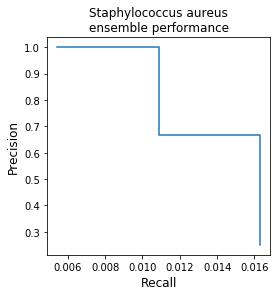

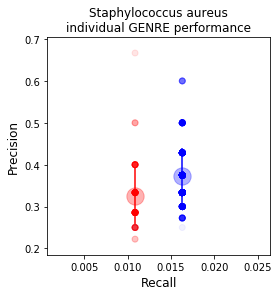

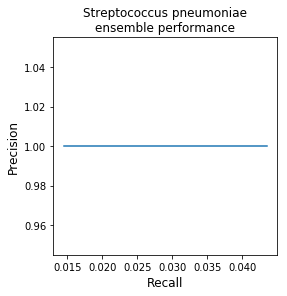

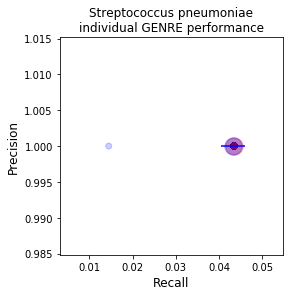

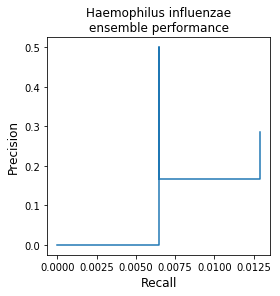

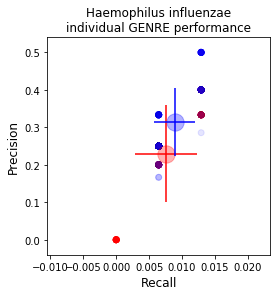

In [40]:
for species in species_w_essentiality:
    fig,ax=plt.subplots()
    stepplot_precision_recall(pop_precision[species],pop_recall[species],ax)
    ax.set_title(species + '\nensemble performance',fontsize=12)
    ax.set_xlabel('Recall',fontsize=12)
    ax.set_ylabel('Precision',fontsize=12)
    fig.set_size_inches(4,4)
    fig.savefig('../results/precision_recall/'+species+'_ensemble_prec_recall.png')
    fig.savefig('../results/precision_recall/'+species+'_ensemble_prec_recall.svg')
    
    
    fig,ax=plt.subplots()
    scatter_precision_recall(ind_precision[species],ind_recall[species],clusters[species],ax)
    ax.set_title(species + '\nindividual GENRE performance',fontsize=12)
    ax.set_xlabel('Recall',fontsize=12)
    ax.set_ylabel('Precision',fontsize=12)
    fig.set_size_inches(4,4)
    fig.savefig('../results/precision_recall/'+species+'_individual_prec_recall.png')
    fig.savefig('../results/precision_recall/'+species+'_individual_prec_recall.svg')

In [20]:
sum([x > 0.001 for x in list(ind_recall['Haemophilus influenzae'].values())])

919